RSI Backtest

We wanted to see if we could come up with an indicator that would serve as a signal to buy and exit a trade before the market reverses in the short term. Can RSI work to make winning trades? 

RSI alone won't work to ensure a winning strategy, but it can be matched with the trend of market to choose to short a high close price that is expected to fall based on the RSI (example 2). An of course RSI can also be used to enter and exit the market in an uptrending market cycle. We tested the model on the Nasdaq ProShares UltraPro Short QQQ ETF (SQQQ). The included heatmap shows the ideal RSI that can be used to optimize cumulative returns. In the future, it would be beneficial to be able to calculate RSI in real-time to know when to enter and exit trades. We did try to come up with such data but it required a steep monthly fee on Alpaca. 

Another option that we explored was to automate trades using webhooks from Tradingview and AWS Lambda to send a JSON response to Alpaca to make a trade. After a lot of work and attemps, it did not function properly. THe Tradingview alerts are initially quite simple, RSI is not an indicator that is available, so it actually would not work as is with our model, but it is possible to program Tradingview with their own programming language Pine Script to use RSI as a signal and to then automate trades. Hopefully in the future these developments can be implemented into our project. 

In [155]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import os
from dotenv import load_dotenv
import json
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import numpy as np
import pandas as pd
import numba
import alpaca
from alpaca import trading
from alpaca.trading.client import TradingClient

from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
import vectorbtpro as vbt
import plotly.graph_objects as go
if not os.path.exists("images"):
    os.mkdir("images")
from IPython.display import Image

In [166]:
API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

In [167]:
vbt.AlpacaData.set_custom_settings(
    client_config=dict(
    api_key=API_KEY,
    secret_key=API_SECRET
))

In [168]:
load_dotenv()

True

In [169]:
trading_client = TradingClient(API_KEY, API_SECRET, paper=True)

In [170]:
api = tradeapi.REST(
        API_KEY,
        API_SECRET,
        api_version="v2")

In [171]:
tickers = ['SQQQ', 'TQQQ', 'QQQ']

In [172]:
timeframe = "1Hour"
start_date = pd.Timestamp("2022-03-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-10-03", tz="America/New_York").isoformat()

In [173]:
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
).df

In [174]:
ticker_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-03-01 05:00:00+00:00,346.5200,346.52,346.34,346.34,264,2,346.408182,QQQ
2022-03-01 06:00:00+00:00,346.8000,347.50,346.80,347.50,1821,5,346.843932,QQQ
2022-03-01 07:00:00+00:00,347.7800,349.10,347.78,348.50,3110,40,348.605794,QQQ
2022-03-01 08:00:00+00:00,347.3000,347.30,345.63,345.63,10777,42,346.270550,QQQ
2022-03-01 09:00:00+00:00,346.9000,346.90,344.08,344.15,78224,563,345.288209,QQQ
...,...,...,...,...,...,...,...,...
2022-09-30 20:00:00+00:00,19.3200,19.58,19.28,19.45,4821295,13546,19.475336,TQQQ
2022-09-30 21:00:00+00:00,19.4400,19.49,19.38,19.43,692837,5572,19.449336,TQQQ
2022-09-30 22:00:00+00:00,19.4300,19.47,19.40,19.45,536206,2006,19.451382,TQQQ


In [175]:
ticker_data_pivoted = ticker_data.pivot(columns='symbol', values=['close', 'open']
)
ticker_data_pivoted

close                    open                
symbol                        QQQ     SQQQ   TQQQ     QQQ   SQQQ     TQQQ
timestamp                                                                
2022-03-01 05:00:00+00:00  346.34  41.0900    NaN  346.52  41.09      NaN
2022-03-01 06:00:00+00:00  347.50  40.7600  52.69  346.80  40.76  52.6900
2022-03-01 07:00:00+00:00  348.50  40.4600  53.00  347.78  40.20  53.0000
2022-03-01 08:00:00+00:00  345.63  40.5000  52.30  347.30  40.40  53.0000
2022-03-01 09:00:00+00:00  344.15  41.7000  51.25  346.90  41.00  52.2800
...                           ...      ...    ...     ...    ...      ...
2022-09-30 20:00:00+00:00  267.87  60.7901  19.45  267.21  61.26  19.3200
2022-09-30 21:00:00+00:00  267.73  60.9100  19.43  267.90  60.80  19.4400
2022-09-30 22:00:00+00:00  267.75  60.8500  19.45  267.74  60.92  19.4300
2022-09-30 23:00:00+00:00  267.70  61.1699  19.36  267.66  60.81  19.4599
2022-10-03 04:00:00+00:00     NaN      NaN  19.15     NaN    NaN  19.1500

[2960 rows x 6 columns]

In [176]:
expected_returns = mean_historical_return(ticker_data_pivoted.get("close"))

In [177]:
expected_returns

symbol
QQQ    -0.021695
SQQQ    0.034467
TQQQ   -0.082613
dtype: float64

In [178]:
cov_matrix = CovarianceShrinkage(ticker_data_pivoted.get("close")).ledoit_wolf()

In [179]:
cov_matrix

symbol,QQQ,SQQQ,TQQQ
symbol,,,
QQQ,0.004867,-0.013731,0.013929
SQQQ,-0.013731,0.043480,-0.042132
TQQQ,0.013929,-0.042132,0.043860


In [180]:
optimizer = EfficientFrontier(expected_returns, cov_matrix)

In [181]:
weights = optimizer.max_sharpe()

In [182]:
weights

OrderedDict([('QQQ', 0.0), ('SQQQ', 1.0), ('TQQQ', 0.0)])

Collecting data using VectorBT Pro for the three ETF's. 

In [82]:
data = vbt.AlpacaData.fetch(
    ['SQQQ', 'TQQQ', 'QQQ'],
    start=pd.Timestamp("2022-09-29", tz="America/New_York").isoformat(),
    end=pd.Timestamp("2022-09-30", tz="America/New_York").isoformat(),
    timeframe='1 minute'
)

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/mikecutno/opt/anaconda3/envs/dev/lib/python3.9/site-packages/vectorbtpro/data/base.py:597: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



Below we will plot the OHLC data for the three ETF's on Septemner 29th, 2022. We will focus on SQQQ because of the recent trends. We are looking for high daily returns on our trades so we need volatility. Whether we buy low and sell high, or buy high and short the stock we need the market to move in one direction, but to get out if it stabilizes.

In [157]:
fig_1 = data.data['SQQQ'].vbt.ohlcv.plot(title= 'OHLC of SQQQ on 9-29-22')

In [158]:
fig_1

FigureWidget({
    'data': [{'close': array([  nan,   nan,   nan, ..., 57.54, 57.56, 57.6 ]),
              'd…

In [159]:
fig_1.write_image("images/fig1.png")

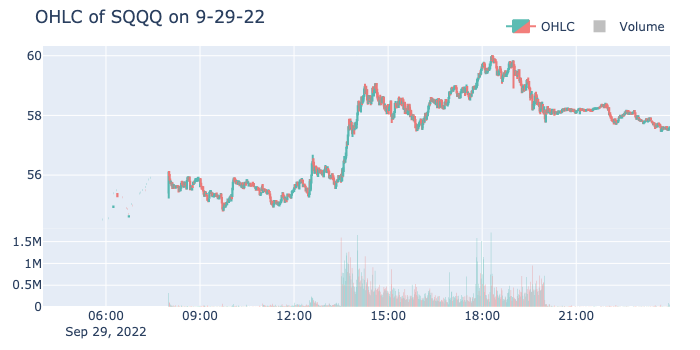

In [160]:
img_1 = 'images/fig1.png'
Image(filename=img_1)

In [161]:
fig_2 = data.data['QQQ'].vbt.ohlcv.plot(title= 'OHLC of QQQ on 9-29-22')
fig_2.write_image("images/fig2.png")
fig_2

FigureWidget({
    'data': [{'close': array([279.93, 279.93,    nan, ..., 273.02, 272.99, 272.94]),
          …

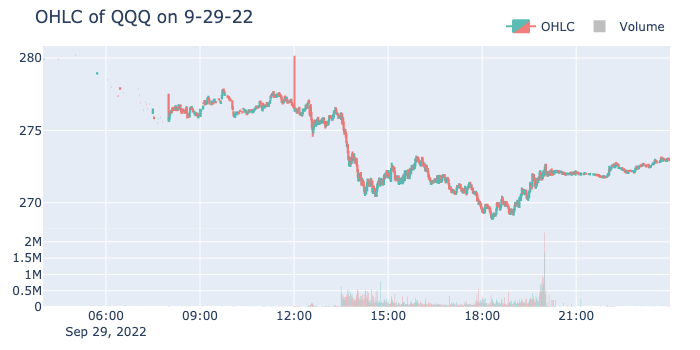

In [163]:
img_2 = 'images/fig2.png'
Image(filename=img_2)

In [164]:
fig_3 = data.data['TQQQ'].vbt.ohlcv.plot(title ='OHLC of TQQQ on 9-29-22')
fig_3.write_image("images/fig3.png")
fig_3

FigureWidget({
    'data': [{'close': array([   nan,    nan, 22.2  , ..., 20.591, 20.59 , 20.57 ]),
          …

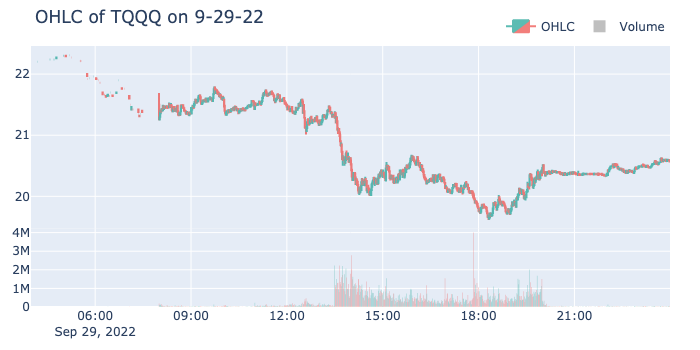

In [165]:
img_3 = 'images/fig3.png'
Image(filename=img_3)

In [ ]:
#data.data['SPXL'].vbt.ohlcv.plot()

In [ ]:
#data.data['SPXU'].vbt.ohlcv.plot()

In [ ]:
#data.data['UPRO'].vbt.ohlcv.plot()

In [ ]:
#data.data['SPXS'].vbt.ohlcv.plot()

In [87]:
#expected_returns_2 = mean_historical_return(data_2.get("Close"))

In [ ]:
#cov_matrix_2 = CovarianceShrinkage(data_2.get("Close")).ledoit_wolf()

In [ ]:
#optimizer_2 = EfficientFrontier(expected_returns_2, cov_matrix_2)

In [ ]:
#weights_2 = optimizer_2.max_sharpe()

In [ ]:
#weights_2

In [88]:
data.data['SQQQ'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1041 entries, 2022-09-29 04:00:00+00:00 to 2022-09-29 23:59:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         979 non-null    float64
 1   High         979 non-null    float64
 2   Low          979 non-null    float64
 3   Close        979 non-null    float64
 4   Volume       979 non-null    float64
 5   Trade count  979 non-null    float64
 6   VWAP         979 non-null    float64
dtypes: float64(7)
memory usage: 65.1 KB


In [89]:
open_price = data.data['SQQQ'].get('Open')
close_price = data.data['SQQQ'].get('Close')


Now that we have our data prepared we can calculate the Relative Strength Index using vectorBTpro.
Then we will find entries and exits based off a range of the RSI. When the RSI crosses above a certain threshold we exit the trade. When it crosses below we enter again assuming that it will ossilate back up. The reverse is true on low sentiment days when we expect the market to trend downards and we decide to short the stock based off of the sentiment analysis. In the case of shorting we exit the trade when the RSI crosses below a certain threshold expecting the close price to go up, but if it reaches our upper RSI we enter the trade again with a short position. 

The module will first come up with all of the entries and exits and then we will clean it up to find the optimal points. 

In [90]:
rsi = vbt.RSI.run(open_price)
rsi


In [91]:
rsi.rsi

Open time
2022-09-29 04:00:00+00:00          NaN
2022-09-29 04:03:00+00:00          NaN
2022-09-29 04:12:00+00:00          NaN
2022-09-29 04:29:00+00:00          NaN
2022-09-29 04:35:00+00:00          NaN
                               ...    
2022-09-29 23:55:00+00:00    38.768153
2022-09-29 23:56:00+00:00    41.316143
2022-09-29 23:57:00+00:00    39.544051
2022-09-29 23:58:00+00:00    42.225994
2022-09-29 23:59:00+00:00    43.554202
Name: Open, Length: 1041, dtype: float64

In [92]:
entries = rsi.rsi.vbt.crossed_below(33.5)  
entries

Open time
2022-09-29 04:00:00+00:00    False
2022-09-29 04:03:00+00:00    False
2022-09-29 04:12:00+00:00    False
2022-09-29 04:29:00+00:00    False
2022-09-29 04:35:00+00:00    False
                             ...  
2022-09-29 23:55:00+00:00    False
2022-09-29 23:56:00+00:00    False
2022-09-29 23:57:00+00:00    False
2022-09-29 23:58:00+00:00    False
2022-09-29 23:59:00+00:00    False
Name: Open, Length: 1041, dtype: bool

In [93]:
exits = rsi.rsi.vbt.crossed_above(67)
exits

Open time
2022-09-29 04:00:00+00:00    False
2022-09-29 04:03:00+00:00    False
2022-09-29 04:12:00+00:00    False
2022-09-29 04:29:00+00:00    False
2022-09-29 04:35:00+00:00    False
                             ...  
2022-09-29 23:55:00+00:00    False
2022-09-29 23:56:00+00:00    False
2022-09-29 23:57:00+00:00    False
2022-09-29 23:58:00+00:00    False
2022-09-29 23:59:00+00:00    False
Name: Open, Length: 1041, dtype: bool

In [190]:
def plot_rsi(rsi, entries, exits):
    fig = rsi.plot(title = "Entries and Exits of SQQQ on 9-29-22")
    entries.vbt.signals.plot_as_entries(rsi.rsi, fig=fig) 
    exits.vbt.signals.plot_as_exits(rsi.rsi, fig=fig)
    return fig

fig_4 = plot_rsi(rsi, entries, exits )
fig_4.write_image("images/fig4.png")
fig_4

FigureWidget({
    'data': [{'line': {'color': '#6ca6cd'},
              'mode': 'lines',
              'name'…

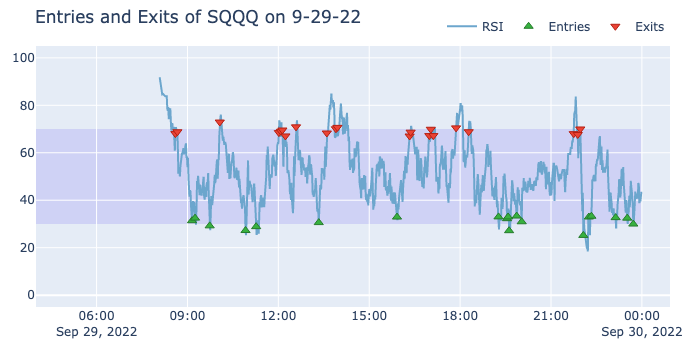

In [191]:
img_4 = 'images/fig4.png'
Image(filename=img_4)

In [192]:
clean_entries, clean_exits = entries.vbt.signals.clean(exits)  

fig_5 = plot_rsi(rsi, clean_entries, clean_exits)
fig_5.write_image("images/fig5.png")
fig_5

FigureWidget({
    'data': [{'line': {'color': '#6ca6cd'},
              'mode': 'lines',
              'name'…

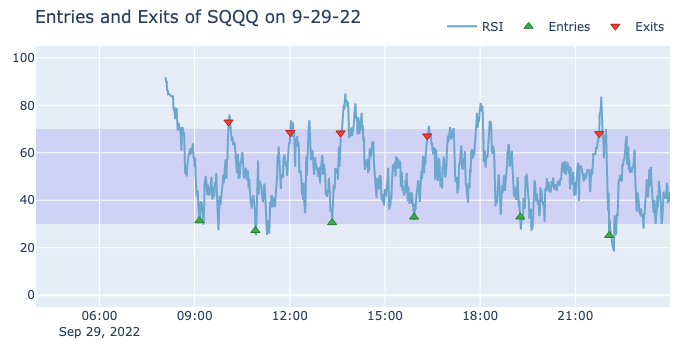

In [199]:
img_5 = 'images/fig5.png'
Image(filename=img_5)

In [96]:
portfolio_sqqq = vbt.Portfolio.from_signals(
    close=close_price,
    entries=clean_entries,
    exits=clean_exits,
    size=5000,
    size_type='value',
    init_cash='auto'
)
portfolio_sqqq


In [97]:
vbt.settings.wrapping['freq'] = '1m'

In [98]:
portfolio_sqqq.stats()

Start                         2022-09-29 04:00:00+00:00
End                           2022-09-29 23:59:00+00:00
Period                                  0 days 17:21:00
Start Value                                      5000.0
Min Value                                   4950.325145
Max Value                                   5254.201467
End Value                                   5136.342543
Total Return [%]                               2.726851
Benchmark Return [%]                           5.668685
Total Time Exposure [%]                       41.018252
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                                2.42343
Max Drawdown Duration                   0 days 04:32:00
Total Orders                                         11
Total Fees Paid                                     0.0
Total Trades                                          6
Win Rate [%]                                       80.0
Best Trade [%]                                 1

In [198]:
fig_6 = portfolio_sqqq.plot(settings=dict(bm_returns=False), title= "SQQQ")
fig_6.write_image("images/fig6.png")
fig_6

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'mo…

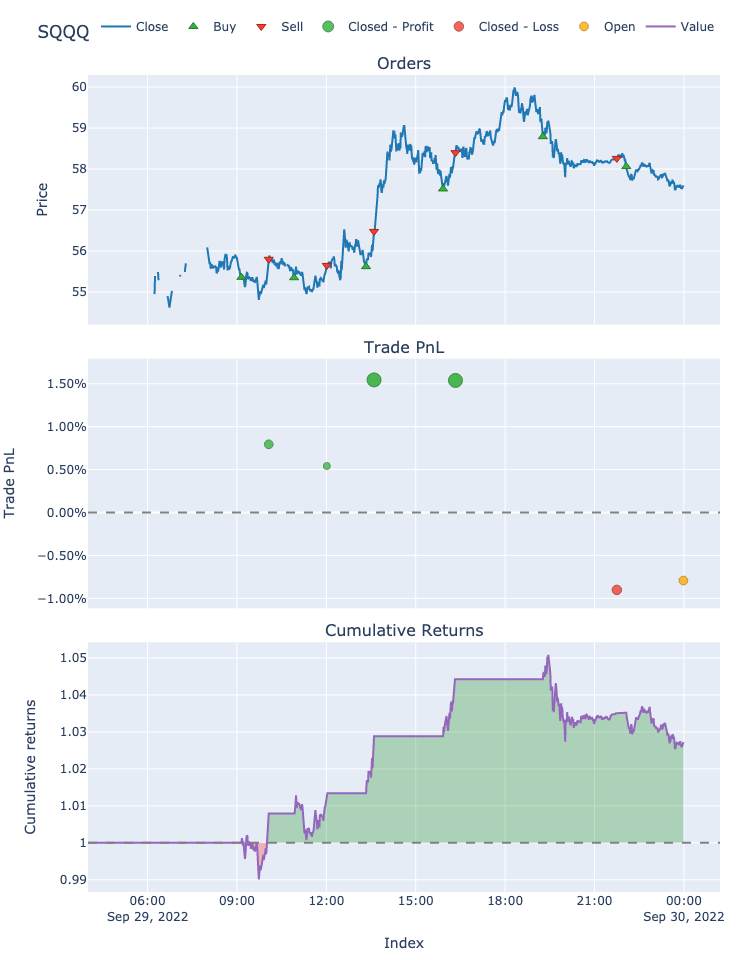

In [200]:
img_6 = 'images/fig6.png'
Image(filename=img_6)

We can test RSI ranges to see what our returns would come out to. 

In [101]:
def test_rsi(window=13, wtype="wilder", lower_th=33.5, upper_th=67):
    rsi = vbt.RSI.run(open_price, window=window, wtype=wtype)
    entries = rsi.rsi_crossed_below(lower_th)
    exits = rsi.rsi_crossed_above(upper_th)
    portfolio_sqqq = vbt.Portfolio.from_signals(
        close=close_price,
        entries=entries,
        exits=exits,
        size=5000,
        size_type='value',
        init_cash='auto')
    return portfolio_sqqq.stats([
        'total_return',
        'total_trades',
        'win_rate',
        'expectancy'
    ])

In [102]:
test_rsi()

Total Return [%]       4.2708
Total Trades                8
Win Rate [%]        85.714286
Expectancy          33.592518
dtype: object

In [103]:
test_rsi(lower_th=30, upper_th=70)

Total Return [%]    1.376086
Total Trades               5
Win Rate [%]            75.0
Expectancy          27.10462
dtype: object

In [104]:
test_rsi(lower_th=33.5, upper_th=67)

Total Return [%]       4.2708
Total Trades                8
Win Rate [%]        85.714286
Expectancy          33.592518
dtype: object

In [105]:
from itertools import product

In [106]:
lower_ths = range(31, 40)  
upper_ths = range(60, 70)  
th_combs = list(product(lower_ths, upper_ths))  
len(th_combs)

90

In [107]:
comb_stats = [
test_rsi(lower_th=lower_th, upper_th=upper_th)
    for lower_th, upper_th in th_combs
]  

In [108]:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df.sort_values(['Total Return [%]'])

,Total Return [%],Total Trades,Win Rate [%],Expectancy
60,0.813910,9,62.500000,8.217877
61,0.902776,9,62.500000,8.773287
80,0.935338,10,66.666667,7.979379
63,0.936426,9,62.500000,8.983601
62,1.003726,9,62.500000,9.404228
...,...,...,...,...
36,4.048351,8,85.714286,33.230855
37,4.098984,8,85.714286,33.592518
38,4.121691,8,85.714286,33.754715
39,4.142698,7,83.333333,41.124847


In [109]:
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs,
    names=['lower_th', 'upper_th'])
comb_stats_df.sort_values(['Total Return [%]'])

Total Return [%]  Total Trades  Win Rate [%]  Expectancy
lower_th upper_th                                                          
37       60                0.813910             9     62.500000    8.217877
         61                0.902776             9     62.500000    8.773287
39       60                0.935338            10     66.666667    7.979379
37       63                0.936426             9     62.500000    8.983601
         62                1.003726             9     62.500000    9.404228
...                             ...           ...           ...         ...
34       66                4.048351             8     85.714286   33.230855
         67                4.098984             8     85.714286   33.592518
         68                4.121691             8     85.714286   33.754715
         69                4.142698             7     83.333333   41.124847
         64                4.916956             9     87.500000   34.505782

[90 rows x 4 columns]

Using a heatmap we will find the optimal upper and lower ends of out RSI range. Which happens to be 34 and 64 for SQQQ. 

In [203]:
fig_7 = comb_stats_df['Total Return [%]'].vbt.heatmap(title = "Lower and Upper RSI Threshold combinations by TR%")
fig_7.write_image("images/fig7.png")
fig_7

FigureWidget({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
               …

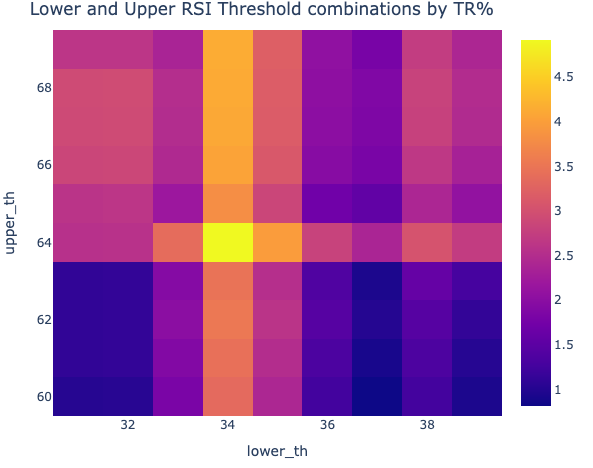

In [204]:
img_7 = 'images/fig7.png'
Image(filename=img_7)

Test on the previous day 10/3/22 with the same RSI indicators, except this is to short SQQQ. 

The short happens here, and is baked into the vbt module: 

portfolio_sqqq_2 = vbt.Portfolio.from_signals(
    close=close_price_2,
    short_entries=clean_entries_2,
    short_exits=clean_exits_2,
    size=5000,
    size_type='value',
    init_cash='auto'
)


In [112]:
data_2 = vbt.AlpacaData.fetch(
    ['SQQQ','QQQ','TQQQ'],
    start="2022-10-03 UTC",
    end="2022-10-04 UTC",
    timeframe="1 minute"
)



  0%|          | 0/3 [00:00<?, ?it/s]

/Users/mikecutno/opt/anaconda3/envs/dev/lib/python3.9/site-packages/vectorbtpro/data/base.py:597: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



On October 3rd when our sentiment analysis tells us that the news is 'bad' and we know the market is going down we can short the stock and make a profit. We just have to swicth our RSI strategy to the shorting strategy, otherwise we would lose money. 

In [205]:
fig_8 = data_2.data['SQQQ'].vbt.ohlcv.plot(title = 'OHLC of SQQQ on 10-03-22')
fig_8.write_image("images/fig8.png")
fig_8

FigureWidget({
    'data': [{'close': array([  nan,   nan,   nan, ..., 56.21, 56.23, 56.14]),
              'd…

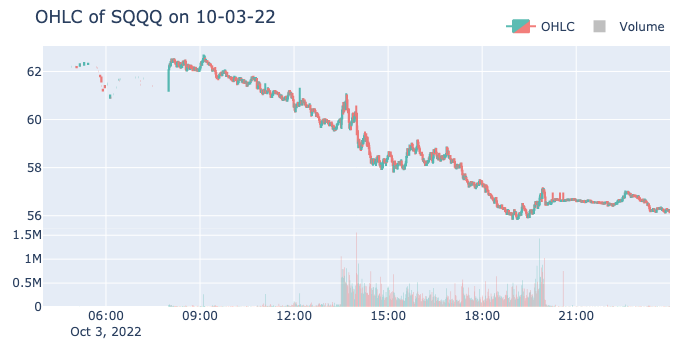

In [206]:
img_8 = 'images/fig8.png'
Image(filename=img_8)

In [114]:
open_price_2 = data_2.data['SQQQ'].get('Open')
close_price_2 = data_2.data['SQQQ'].get('Close')

In [115]:
rsi_2 = vbt.RSI.run(open_price_2)
rsi_2

In [116]:
rsi_2.rsi

Open time
2022-10-03 04:00:00+00:00          NaN
2022-10-03 04:07:00+00:00          NaN
2022-10-03 04:09:00+00:00          NaN
2022-10-03 04:10:00+00:00          NaN
2022-10-03 04:11:00+00:00          NaN
                               ...    
2022-10-03 23:55:00+00:00    47.456023
2022-10-03 23:56:00+00:00    43.377368
2022-10-03 23:57:00+00:00    47.052849
2022-10-03 23:58:00+00:00    44.957669
2022-10-03 23:59:00+00:00    43.904971
Name: Open, Length: 1049, dtype: float64

In [117]:
entries_2 = rsi_2.rsi.vbt.crossed_below(38)  
entries_2

Open time
2022-10-03 04:00:00+00:00    False
2022-10-03 04:07:00+00:00    False
2022-10-03 04:09:00+00:00    False
2022-10-03 04:10:00+00:00    False
2022-10-03 04:11:00+00:00    False
                             ...  
2022-10-03 23:55:00+00:00    False
2022-10-03 23:56:00+00:00    False
2022-10-03 23:57:00+00:00    False
2022-10-03 23:58:00+00:00    False
2022-10-03 23:59:00+00:00    False
Name: Open, Length: 1049, dtype: bool

In [118]:
exits_2 = rsi_2.rsi.vbt.crossed_above(67)
exits_2

Open time
2022-10-03 04:00:00+00:00    False
2022-10-03 04:07:00+00:00    False
2022-10-03 04:09:00+00:00    False
2022-10-03 04:10:00+00:00    False
2022-10-03 04:11:00+00:00    False
                             ...  
2022-10-03 23:55:00+00:00    False
2022-10-03 23:56:00+00:00    False
2022-10-03 23:57:00+00:00    False
2022-10-03 23:58:00+00:00    False
2022-10-03 23:59:00+00:00    False
Name: Open, Length: 1049, dtype: bool

In [207]:
def plot_rsi(rsi_2, entries_2, exits_2):
    fig = rsi_2.plot(title = "Entries and Exits of SQQQ on 10-03-22")
    entries_2.vbt.signals.plot_as_entries(rsi_2.rsi, fig=fig)  
    exits_2.vbt.signals.plot_as_exits(rsi_2.rsi, fig=fig)
    return fig

fig_9 = plot_rsi(rsi_2, entries_2, exits_2)
fig_9.write_image("images/fig9.png")
fig_9

FigureWidget({
    'data': [{'line': {'color': '#6ca6cd'},
              'mode': 'lines',
              'name'…

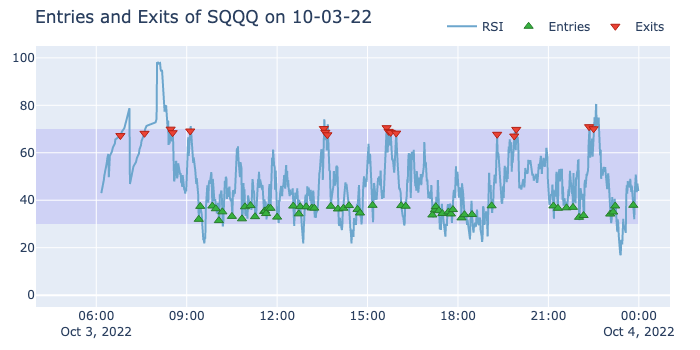

In [208]:
img_9 = 'images/fig9.png'
Image(filename=img_9)

In [209]:
clean_entries_2, clean_exits_2 = entries_2.vbt.signals.clean(exits_2)  

fig_10 = plot_rsi(rsi_2, clean_entries_2, clean_exits_2)
fig_10.write_image("images/fig10.png")
fig_10

FigureWidget({
    'data': [{'line': {'color': '#6ca6cd'},
              'mode': 'lines',
              'name'…

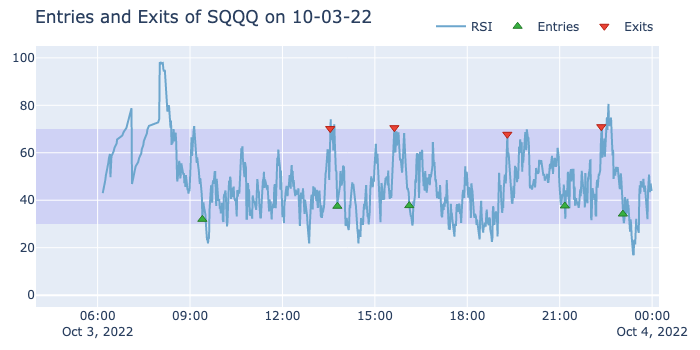

In [210]:
img_10 = 'images/fig10.png'
Image(filename=img_10)

In [121]:
portfolio_sqqq_2 = vbt.Portfolio.from_signals(
    close=close_price_2,
    short_entries=clean_entries_2,
    short_exits=clean_exits_2,
    size=5000,
    size_type='value',
    init_cash='auto'
)



In [122]:
portfolio_sqqq_2

In [123]:
portfolio_sqqq_2.stats()

Start                         2022-10-03 04:00:00+00:00
End                           2022-10-03 23:59:00+00:00
Period                                  0 days 17:29:00
Start Value                                      5000.0
Min Value                                   4995.970991
Max Value                                   5430.698998
End Value                                    5429.81623
Total Return [%]                               8.596325
Benchmark Return [%]                          -9.742765
Total Time Exposure [%]                       64.728313
Max Gross Exposure [%]                        108.53155
Max Drawdown [%]                               2.306613
Max Drawdown Duration                   0 days 04:51:00
Total Orders                                          9
Total Fees Paid                                     0.0
Total Trades                                          5
Win Rate [%]                                       75.0
Best Trade [%]                                 3

In [124]:
def test_rsi_2(window=13, wtype="wilder", lower_th=29, upper_th=70):
    rsi = vbt.RSI.run(open_price_2, window=window, wtype=wtype)
    entries_2 = rsi_2.rsi_crossed_below(lower_th)
    exits_2 = rsi_2.rsi_crossed_above(upper_th)
    portfolio_sqqq_2 = vbt.Portfolio.from_signals(
        close=close_price_2,
        short_entries=entries_2,
        short_exits=exits_2,
        size=5000,
        size_type='value',
        init_cash='auto')
    return portfolio_sqqq_2.stats([
        'total_return',
        'total_trades',
        'win_rate',
        'expectancy'
    ])

In [125]:
test_rsi_2()

Total Return [%]     4.845938
Total Trades                4
Win Rate [%]            100.0
Expectancy          70.146157
dtype: object

In [126]:
lower_ths = range(31, 40)  
upper_ths = range(60, 70)  
th_combs = list(product(lower_ths, upper_ths))  
len(th_combs)

90

In [127]:
comb_stats_2 = [
test_rsi_2(lower_th=lower_th, upper_th=upper_th)
    for lower_th, upper_th in th_combs
]  

In [128]:
comb_stats_2_df = pd.DataFrame(comb_stats_2)
comb_stats_2_df.sort_values(['Total Return [%]'])

,Total Return [%],Total Trades,Win Rate [%],Expectancy
2,1.943060,7,50.000000,9.555504
10,2.192705,9,50.000000,8.660359
11,2.271876,9,50.000000,9.145437
12,2.626546,8,57.142857,12.955896
0,2.844723,7,66.666667,16.933351
...,...,...,...,...
66,7.801110,5,75.000000,86.479265
67,8.137638,5,75.000000,90.685875
76,8.261541,5,75.000000,92.234661
75,8.261541,5,75.000000,92.234661


In [129]:
comb_stats_2_df.index = pd.MultiIndex.from_tuples(
    th_combs,
    names=['lower_th', 'upper_th'])
comb_stats_2_df.sort_values(['Total Return [%]'])

Total Return [%]  Total Trades  Win Rate [%]  Expectancy
lower_th upper_th                                                          
31       62                1.943060             7     50.000000    9.555504
32       60                2.192705             9     50.000000    8.660359
         61                2.271876             9     50.000000    9.145437
         62                2.626546             8     57.142857   12.955896
31       60                2.844723             7     66.666667   16.933351
...                             ...           ...           ...         ...
37       66                7.801110             5     75.000000   86.479265
         67                8.137638             5     75.000000   90.685875
38       66                8.261541             5     75.000000   92.234661
         65                8.261541             5     75.000000   92.234661
         67                8.596325             5     75.000000   96.419453

[90 rows x 4 columns]

In [130]:
test_rsi_2(lower_th=38, upper_th=67)

Total Return [%]     8.596325
Total Trades                5
Win Rate [%]             75.0
Expectancy          96.419453
dtype: object

We can see that our strategy works on days when the market is trending downward.
It's even possivle to see higher returns than on an upward trending day. 

In [211]:
fig_11 = portfolio_sqqq_2.plot(title = "SQQQ", settings=dict(bm_returns=False))
fig_11.write_image("images/fig11.png")
fig_11

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'mo…

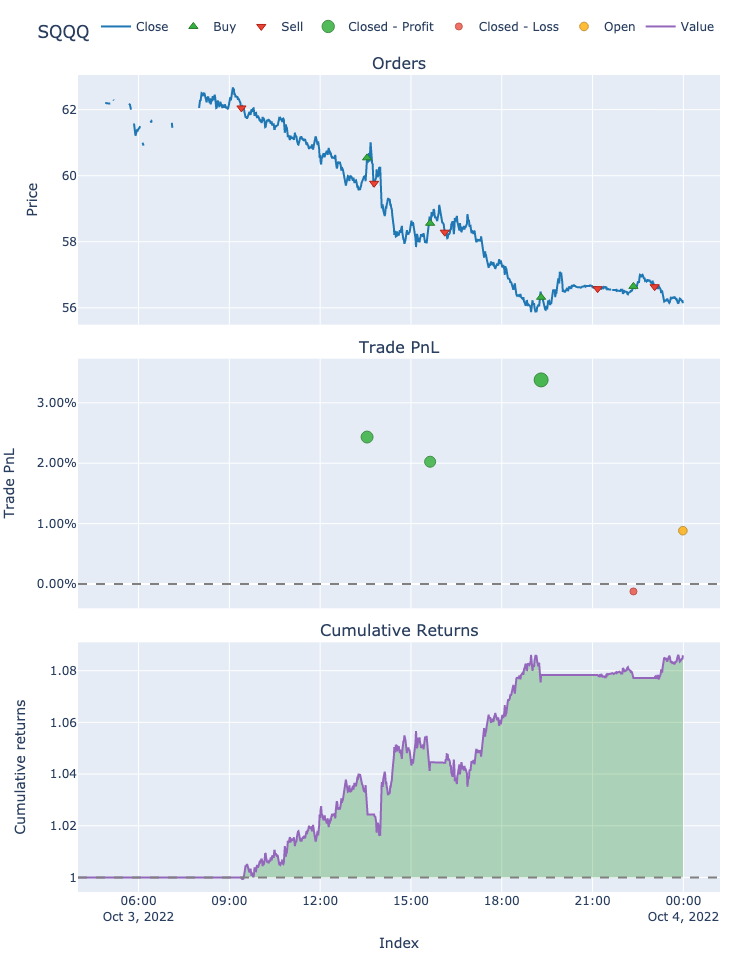

In [212]:
img_11 = 'images/fig11.png'
Image(filename=img_11)

The optimum RSI combination on this day was 67 and 38. Not every day will be the same so we will have to come up with a model to guess the optimum RSI in real-time. 

In [213]:
fig_12 = comb_stats_2_df['Total Return [%]'].vbt.heatmap(title = "Lower and Upper RSI Threshold combinations by TR%")
fig_12.write_image("images/fig12.png")
fig_12

FigureWidget({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
               …

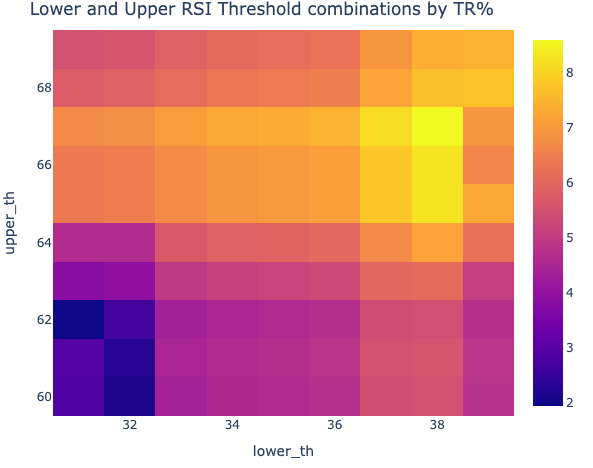

In [214]:
img_12 = 'images/fig12.png'
Image(filename=img_12)

In [134]:
#data_3 = vbt.AlpacaData.fetch(
    #['SQQQ','QQQ','TQQQ'],
    #start="2022-10-04 UTC",
    #end="2022-10-05 UTC",
    #timeframe="1 minute"
#)



  0%|          | 0/3 [00:00<?, ?it/s]

/Users/mikecutno/opt/anaconda3/envs/dev/lib/python3.9/site-packages/vectorbtpro/data/base.py:597: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



In [154]:
#data_3.data['SQQQ'].vbt.ohlcv.plot()

In [ ]:
#market_order_data_buy = MarketOrderRequest(
                    #symbol="SQQQ",
                    #qty=71,
                    #side=OrderSide.BUY,
                    #time_in_force=TimeInForce.DAY
                    #)

In [ ]:
#market_order_data = MarketOrderRequest(
                    #symbol="SPY",
                    #qty=15,
                    #side=OrderSide.BUY,
                    #time_in_force=TimeInForce.DAY
                    #)

In [ ]:
#market_order = trading_client.submit_order(
                #order_data=market_order_data
               #)

In [ ]:
#market_order_data_sell = MarketOrderRequest(
                    #symbol="SQQQ",
                    #qty=71,
                    #side=OrderSide.SELL,
                    #time_in_force=TimeInForce.DAY